Status: ✅ Done

## Exercise 14

---

In this exercise, we will continue our exploration of ensemble methods. Afer the recap of core concepts, we will implement a light version of `AdaBoost` to get firm understanding of it. Then, we will advance to more practical exercises whose aim will be to actually use the ensemble models on the `MNIST` image data.

> Import

In [ ]:
import math
from collections import Counter
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme()

from sklearn.datasets import load_digits
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score 
from sklearn.base import clone

import warnings
warnings.filterwarnings("ignore")

### Recap of the core theoretical concepts

---

> Important note

The below subsections are essentially summarizing my own notes on ensemble methods, therefore if you want all nitty gritty details, please visit my [notes](https://ludekcizinsky.notion.site/Ensemble-methods-01a3876e838f4a19a791972d1481701f).

> Ideology behind ensemble methods

In the previous exercise, you could see that in the ideal world where we have a lot of models whose predictions are independent of each other, we can achieve perfect performance on any task using the models' predictions as an input to make our final decision (e.g. via hard voting). Of course, in the practical world, things are not that easy since it is near impossible to achieve independence between models.

While it might be impossible, it is still worth trying to achieve. And the way to achieve this is via `diversity`. So how can we introduce diversity to our ensemble model building? Well, essentially, there are two ways:

- `data`: we train our models on different datasets
- `models`: we use models with different hyper-parameters or even model from a different family (e.g. DT classifier and Logistic regression)

Both of these ways can be combined, and in practice they are combined. In the below section, we will explore how.

> Bagging vs Boosting

As discussed above, ensemble models on its own have an ideology which makes it different from other models, i.e., combining a lot of diverse models together. Yet, as it happens in the normal world as well, we also have two separate ideologies inside ensemble models, namely `bagging` and `boosting`. I can totally see the question coming: which is better? And the answer is: it depends on the problem at hand! 😅 Below, I will first discuss both approaches separately and then in the final part of this subsection I will compare them.

`Bagging`, a.k.a. *bootstrapped aggregation*, creates/bootstraps several different training datasets based on the original training dataset and then trains selected models on them. We then have to aggregate the output of the models using some aggregation function. (see previous exercise where we discussed these extensively) These models can be of the same family, or can just differ in hyper-parameters or do not differ at all. As I have mentioned above, bagging introduces `diversity` both in the sense of `data` as well as `models`. The main example of bagging algorithms are:
- `Random forest`: you can train several `decision trees` on the bootstrapped datasets, the trained trees not only differ in on what data they were trained, but also how they were trained - at each split, you only `consider k` features which are `randomly selected`. 

- `Extremely randomised trees`: technically, there is no bootstrapping going on since each of the trees is trained on the original dataset. When training, you also `select k features randomly`, but then the `best split` for each of these features is also chosen `randomly`

- `(Any other ensemble method that can train models in parallel)`: the above methods are pre-defined, but you can of course create your own bagging ensemble method. The main feature that it has to have is that the models can be trained in parallel

Main ideology of bagging is that we want the models to be independent of each other which, as we will discuss in a second, is not case for boosting. This independency requirement has the following advantages:

- models can be trained in parallel (a big plus in this age)
- we decrease variance of performance of the model on training and test data
- as we get vote from each classifier, we can look at the variance of these votes to determine how confident our model is
- as we have shown in the previous exercise, roughly 37 % of samples from the original dataset do not end up in the bootstrapped dataset, therefore we can use these as a validation dataset

While bagging is built around idea of training the individual models independently of each other, `boosting` takes a different route by training each model on the mistakes from the previous model. Therefore, `boosting` is a `sequence` of models where each model in the chain depends on the predictions of the previous model. Again, `diversity` is introduced both via data as well as models. However, when it comes to the diversity in data, notice how the approach is very different from bagging. Bagging just wants each model to look at different snapshot of the original dataset, there is no logic in which model gets which bootstrapped dataset. Whereas in boosting, we alter the input to each model in the sequence based on the mistakes of the previous model. The main two boosting models that we have discussed in the lecture were

- `AdaBoost`: based on the mistakes of the previous model, resample the dataset such that in the input data for the next model, you have more of the problematic cases

- `Gradient Boost`: use residuals as new target values for the next model in the sequence

From these examples, you can see that again despite being from the same ideology (boosting), they approach it differently. While `AdaBoost` plays around which samples go to the next model in the sequence, `Gradient boosts` is altering the target variable. (the idea of the author was that making tiny steps in the right direction should result in overall great result)

In summary, the main three `differences` between `bagging and boosting` are:

- Training and prediction can be run in parallel for bagging, not for boosting (**sequential**)
- Bagging reduces variance whereas boosting reduces bias
- For bagging, as the prediction is an average of many classifiers, you obtain a mean score and score variance. This variance can be interpreted as the uncertainty of the prediction.

> Section summary

In this section, the main focus was on recapping three core concepts:
- what is the idea behind `ensemble methods`
- what is `bagging` and `boosting` with concrete examples
- what is the difference between the two

### AdaBoost implementation

---

> Intro to the problem

We are given a simple dataset:

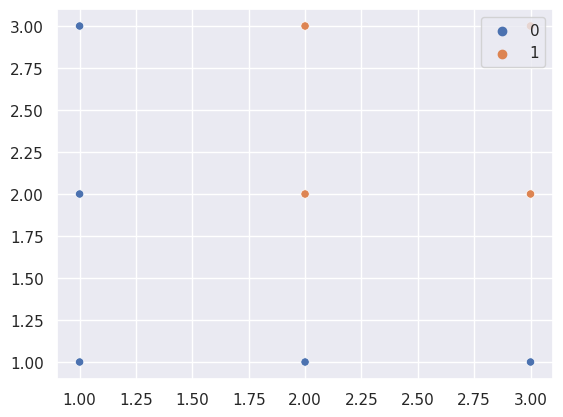

In [ ]:
# Hard code the data set
X = np.array([[1, 1], [1, 2], [1, 3], [2, 1], [2, 2], [2, 3], [3, 1], [3, 2], [3, 3]])
y = np.array([0, 0, 0, 0, 1, 1, 0, 1, 1])

# Visualize it
fig, ax = plt.subplots();
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax);

And our goal is fairly simple:
- use `AdaBoost` to classify the above samples
- use `3 DecisionTrees` with `max_depth=1`
- evaluate this model using simple training error as well as show its decision region

> Implementation

Let's get into implementation. Look into my [notes](https://ludekcizinsky.notion.site/Ensemble-methods-01a3876e838f4a19a791972d1481701f)) for reference on what are the steps.

In [ ]:
class SimpleAdaBoostClassifier:
    """Boosting ensemble classifier using AdaBoost algorithm

    Attributes
    ----------
    model : sklearn model
        sklearn model with parameters set (e.g. DecisionTreeClassifier(max_depth=1))
    
    steps : int
        Number of models to be trained as part of the ensemble
    
    alpha : float
        Value used when computing importance of each model. The higher, the more importance we
        give to the assigned weight to the given model

    n : int
        Number of training samples

    weights : 2d array
        n x steps array - these weights are used for resampling of training data which is then fed into
        given model. J-th column corresponds to weights that were used to get training dataset for J-th model
    
    training : 2d aarray
        n x steps - indices of training samples that were input to the J-th model
    
    models_weight : list
        Weight assigned to each model based on its performance.
    
    trained_models : list
        Collection of trained models.
    """

    def __init__(self, model, steps=3, alpha=.5):
        self.model = model
        self.steps = steps
        self.alpha = alpha

        self.n = None
        self.weights = None
        self.training = None
        self.models_weight = []
        self.trained_models = []

    def _eval_performance(self, y, yhat, weights, idx):
        """Returns model importance and new sample weights

        Attributes
        ----------
        y : 1D array
            Input true classes
        
        yhat : 1D array
            Predicted classes
        
        weights : 1D array
            Weights of the samples that were used to select the training data for the current model
        
        idx : 1D array
            Ids of the samples used for training given model
        
        Returns
        -------
        importance : float
            The higher the better. The less mistakes model makes, the higher the score.
        
        new_weights : 1D array
            n x 1 array with new weights of samples that will be used to obtain
            training data for next model in the sequence
        """
        
        # Compute r
        idx_miss = idx[y != yhat]
        r = weights[idx_miss].sum()/weights[idx].sum()

        # Compute models weights (+ some random small number is to avoid division by zero)
        importance = self.alpha*np.log((1 - r)/(r + 0.0000001))

        # Update sample weights
        new_weights = np.copy(weights)
        c = math.exp(importance)
        new_weights[np.unique(idx_miss)] = new_weights[np.unique(idx_miss)]*c

        # Normalize sample weights
        total = new_weights.sum()
        new_weights = (new_weights/total).reshape(-1, 1)

        return importance, new_weights
    
    def _bootstrap(self, weights):
        """Bootstraps new datasets based on the provided weights
        """
        return np.random.choice(self.n, (self.n, 1), replace=True, p=weights)
    
    def fit(self, X, y, weights=None):
        """Fits the whole ensemble

        Attributes
        ----------
        X : 2D array
            Training data
        
        y : 1D array
            Target values
        
        weights : 2D array
            Array of shape n x 1 where each value represents weight of given sample
        """

        # Extract number of training samples
        self.n = X.shape[0]

        # Assign initial weight to training samples
        if weights is not None:
            self.weights = weights # custom
        else:
            self.weights = np.full((self.n, 1), 1/self.n) # default
        
        # Create the dataset for the first model to train on
        # based on the weights
        self.training = self._bootstrap(self.weights[:, 0])
        
        # Train the ensemble
        for i in range(self.steps):
            
            # Initialize new instance of the model
            model = clone(self.model)

            # Train that instance
            idx = self.training[:, i] # idx of selected samples
            model = model.fit(X[idx], y[idx])
            self.trained_models.append(model)

            # Make a prediction on training
            yhat = model.predict(X[idx])

            # Compute importance of model and get new weights
            a, new_weights = self._eval_performance(y[idx], yhat, self.weights[:, i], idx)

            # Save the model importance and new weights
            self.models_weight.append(a)
            self.weights = np.hstack((self.weights, new_weights))

            # Finally resample so the next model has new input
            if i < (self.steps - 1):
                new_samples_idx = self._bootstrap(new_weights[:, 0])
                self.training = np.hstack((self.training, new_samples_idx))

    def predict_proba(self, X):
        """Predict probability for each input.

        We take weighted average of models' probability predictions.
        """
        
        result = None
        for i in range(self.steps):
            yhat = self.models_weight[i]*self.trained_models[i].predict_proba(X)

            if result is None:
                result = yhat
            else:
                result += yhat
        
        return result/sum(self.models_weight)
    
    def predict(self, X):
        """Predicts class with highest posterior probability.
        """
        return np.argmax(self.predict_proba(X), axis=1)

Let's test it out. We first fit the model:

In [ ]:
model = DecisionTreeClassifier(random_state=42, max_depth=1)
clf = SimpleAdaBoostClassifier(model, steps=3, alpha=.5)
clf.fit(X, y)

And now we can try to calculate `test error`:

In [ ]:
yhat = clf.predict(X)
error = 1 - accuracy_score(y, yhat)
print("Training error: {:.3f}".format(error))

Training error: 0.000


Not bad 🥳 You can of course try different hyper-parameters, e.g. `max_depth = 2`, which would improve the performance.

> Visualise the decision regions

In this section, I will visualize the decision regions of our fitted model as well as its individual trees:

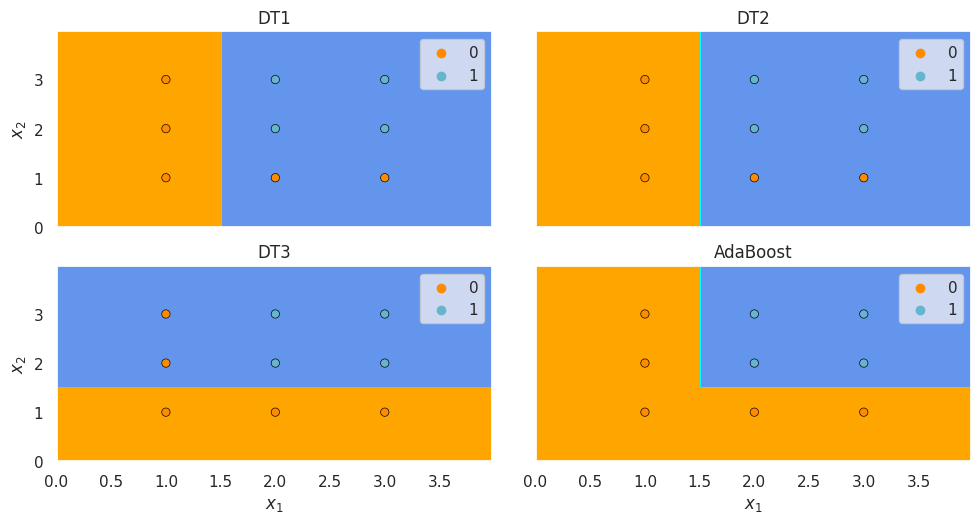

In [ ]:
# Define plot 
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define classifiers
clfs = [clf.trained_models[:2], [clf.trained_models[2], clf]]

# Define titles
titles = [["DT1", "DT2"], ["DT3", "AdaBoost"]]

# Mesh step
h = 0.02

for i in range(2):
    for j in range(2):
        
        # Get ax
        ax = axs[i, j]

        # Plot the decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        Z = clfs[i][j].predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
        ax.set_xlim(xx.min(), xx.max());
        ax.set_ylim(yy.min(), yy.max());
        ax.set_title(titles[i][j]);
        ax.set_xlabel("$x_1$");
        ax.set_ylabel("$x_2$");

This nicely shows the learning process of `AdaBoost`!

> Section summary

After going through this section, you should have pretty good understaning of `AdaBoost`. The implementation itself introduced several challenges such as how do we keep track of all the weights, how do we resample, how do we then predict. But I believe the result is pretty cool 😎

### AdaBoost vs other models

---

> Intro to the problem

In this exercise, our focus will be on comparing decision regions of `AdaBoost` to the other classifier that we we learnt about in this course, namely `Logistic Regression`, `QDA` and `LDA`. For this we will use the usual dataset:

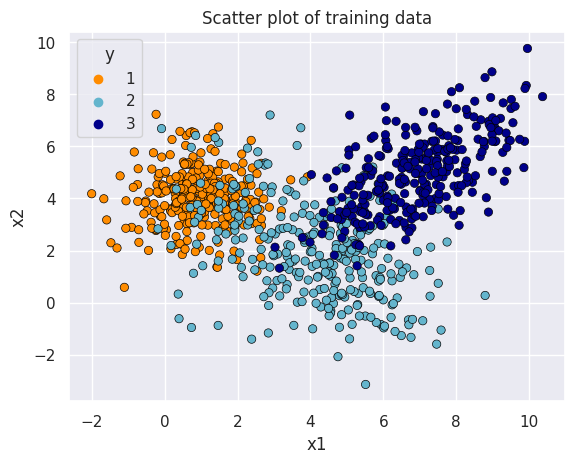

In [ ]:
# Training
training = pd.read_csv("Ex1-training.csv")
X_train, y_train = training[["x1", "x2"]], training["y"]

# Test
test = pd.read_csv("Ex1-test.csv")
X_test, y_test = test[["x1", "x2"]], test["y"]

# Plot training
fig, ax = plt.subplots()
cmap_bold = ['darkorange', 'c', 'darkblue']
sns.scatterplot(x="x1", y="x2", hue="y", data=training, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
ax.set_title("Scatter plot of training data");

> Visualising the decision regions

Let's get into the plotting. For the `AdaBoost`, I will use as a base classifier `DecisionTree` with `max depth = 1`.

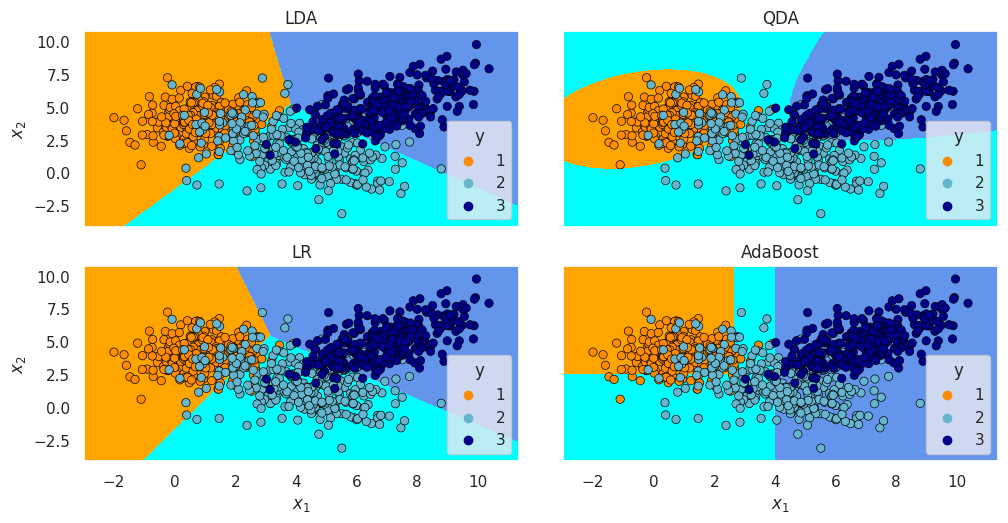

In [ ]:
# Define plot 
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharex=True, sharey=True)
plt.tight_layout();
fig.subplots_adjust(wspace=0.1, hspace=.2);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define classifiers
clfs = [[LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis()],
        [LogisticRegression(), AdaBoostClassifier(n_estimators=100, random_state=42)]]

# Define titles
titles = [["LDA", "QDA"], ["LR", "AdaBoost"]]

# Mesh step
h = 0.02

for i in range(2):
    for j in range(2):
        
        # Get ax
        ax = axs[i, j]

        # Make the meshgrid
        x_min, x_max = X_train["x1"].min() - 1, X_train["x1"].max() + 1
        y_min, y_max = X_train["x2"].min() - 1, X_train["x2"].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # Fit the model
        model = clfs[i][j].fit(X_train, y_train)
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cmap_light)

        # Plot also the training points
        sns.scatterplot(x=X_train["x1"], y=X_train["x2"], hue=y_train, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
        ax.set_xlim(xx.min(), xx.max());
        ax.set_ylim(yy.min(), yy.max());
        ax.set_title(titles[i][j]);
        ax.set_xlabel("$x_1$");
        ax.set_ylabel("$x_2$");

Interesting 😬 We can see that `LDA` and `LR` have similar approaches which makes sense given the fact that both are `linear models`. Clearly, `QDA` is most flexible which we would also expect by its definition. Finally, `AdaBoost` gives this straight-ish boundaries which also makes sense since its base classifier are decision trees with max depth 1. If we wanted more complexity, we could increase the depth to reduce model' bias.

> Section summary

In this section, we put `AdaBoost` against other classifiers that we have leant about. As we could see, the way how `AdaBoost` makes classification of course depends on what type of base model we choose.

### Building custom ensemble model

---

> Intro to the problem

In this section, we will build several individual models on [MNIST dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset), test their individual performance and then try to increase the performance by combining all these models together using `soft voting`. Let's first load the dataset and make train-validation-test split:

In [ ]:
# Load data
X, y = load_digits(return_X_y=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Show training shape
X_train.shape

(806, 64)

Note that each row represents an image, read more [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset) about what the attributes actually represent. For our task, it is not that important to understand.

> Training all classifiers and see their individual performance

Let's start with defining the individual models:

In [ ]:
# Define models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
extree = ExtraTreesClassifier(n_estimators=100, random_state=42)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
ada = AdaBoostClassifier(n_estimators=50, random_state=42)

# Store them as a collection for each handling
clfs = [rf, extree, lda, qda, ada]
names = ['RF', 'Extree', 'LDA', 'QDA', 'ADA']

Next, we want to train them and report validation performance (`macro f1-score`):

In [ ]:
for i, clf in enumerate(clfs):

    # Train
    clf.fit(X_train, y_train)

    # Predict on val
    yhat = clf.predict(X_val)

    # Compute f1
    f1 = f1_score(y_val, yhat, average='macro')

    # Report it
    print(f"Performance of {names[i]}\n---")
    print(">> Macro F1: {:.3f}".format(f1))
    print()

Performance of RF
---
>> Macro F1: 0.972

Performance of Extree
---
>> Macro F1: 0.977

Performance of LDA
---
>> Macro F1: 0.948

Performance of QDA
---
>> Macro F1: 0.761

Performance of ADA
---
>> Macro F1: 0.222



We already got pretty good performance. Our next step will be `try to` beat it by creating `custom ensemble` from these models.

> Custom ensemble

For simplicity, I will define a simple class for our custom ensemble:

In [ ]:
class CustomEnsembleClassifier:

    def __init__(self, models):
        self.models = models
    
    def _get_avg_probs(self, X):

        # Compute average of probabilites
        probs = None
        for model in self.models:
            prob = model.predict_proba(X)
            if probs is not None:
                probs += prob
            else:
                probs = prob
        
        result = probs_avg = probs/len(self.models)

        return result
    
    def _soft_voting(self, X):
        
        # Compute average of probabilites for each class
        probs_avg = self._get_avg_probs(X)

        # Select class with highest average
        return np.argmax(probs_avg, axis = 1)
    
    @staticmethod
    def _select_most_frequent_label(x):
        label_count = [(label, count) for label, count in Counter(x).items()]
        yhat = sorted(label_count, reverse=True, key=lambda x: x[1])[0][0]
        return yhat
    
    def _get_all_predictions(self, X):

        # Save predictions of each model (column)
        predictions = None
        for model in self.models:

            # Predict values
            pred = model.predict(X).reshape(-1, 1)

            # Save it
            if predictions is None:
                predictions = pred
            else:
                predictions = np.hstack((predictions, pred))
        
        return predictions
    
    def _hard_voting(self, X):

        # Save predictions of each model (column)
        predictions = self._get_all_predictions(X)
        
        # For each row, select most frequent label
        return np.apply_along_axis(self._select_most_frequent_label, 1, predictions)

    def predict_raw(self, X, how='soft'):
        
        if how == 'soft':
            return self._get_avg_probs(X)
        elif how == 'hard':
            return self._get_all_predictions(X)
        else:
            print(f"{how} is not implemented")

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
    
    def predict(self, X, how='soft'):
        
        if how == 'soft':
            return self._soft_voting(X)
        elif how == 'hard':
            return self._hard_voting(X)
        else:
            print(f"{how} is not implemented")

We now define the exact same individual models:

In [ ]:
# Define models that will go into ensemble
m1 = RandomForestClassifier(n_estimators=100, random_state=42)
m2 = ExtraTreesClassifier(n_estimators=100, random_state=42)
m3 = LinearDiscriminantAnalysis()
m4 = QuadraticDiscriminantAnalysis()
m5 = AdaBoostClassifier(n_estimators=50, random_state=42)
models = [m1, m2, m3, m4, m5]

# Initialize the custom ensemble
customen = CustomEnsembleClassifier(models)

Let's now try to evaluate the performance of our custom ensemble on the `validation data`:

In [ ]:
# Train
customen.fit(X_train, y_train)

# Predict
yhatsoft = customen.predict(X_val, how='soft')
yhathard = customen.predict(X_val, how='hard')

# Evaluate
f1soft = f1_score(y_val, yhatsoft, average='macro')
f1hard = f1_score(y_val, yhathard, average='macro')

# Report it
print(f"Performance of Custom ensemble model on validation set\n---")
print(">> Macro F1 soft: {:.3f}".format(f1soft))
print(">> Macro F1 hard: {:.3f}".format(f1hard))
print()

Performance of Custom ensemble model on validation set
---
>> Macro F1 soft: 0.969
>> Macro F1 hard: 0.977



Using the `hard voting` method, we were able to achieve the same performance as the best individual model. I would say that in this particular case, it is relatively hard to make more improvements since the performance is already high. Of course, if you try to play around this bit more, you might be able to find collection of ensemble methods that would outperform individual method. With that being said, I believe that in this particular case, it is better to use individual classifier since it requires less processing in terms of training as well as predictions. 

Let's now evaluate our ensemble also on `test data` and compare it with the best individual model:

In [ ]:
# Predict
yhat = extree.predict(X_test)
yhatsoft = customen.predict(X_test, how='soft')
yhathard = customen.predict(X_test, how='hard')

# Evaluate
f1 = f1_score(y_test, yhat, average='macro')
f1soft = f1_score(y_test, yhatsoft, average='macro')
f1hard = f1_score(y_test, yhathard, average='macro')

# Report it
print(f"Performance of Custom ensemble model on validation set\n---")
print(">> Macro F1 soft: {:.3f}".format(f1soft))
print(">> Macro F1 hard: {:.3f}".format(f1hard))
print()
print(f"Performance of Extra treee classifier\n---")
print(">> Macro F1: {:.3f}".format(f1))

Performance of Custom ensemble model on validation set
---
>> Macro F1 soft: 0.964
>> Macro F1 hard: 0.969

Performance of Extra treee classifier
---
>> Macro F1: 0.977


This is aligned with what I wrote in the previous paragraph - in this particular case, it seems more reasonable to go with single model rather than ensemble. 

> Section summary

In this section, we built our own ensemble method. The main learning point is that it is not neccessary always the case that ensemble of models will outpeform individual model. This is because by inviting more models to have say in the final decision, you are inherently adding new noise to the final decision. This again another proof of that there is no single rule of thumb when to use which particular model.

### Stacking

---

> Intro to the problem

You can say that stacking is yet another way of how one can aggregate results from several models. Of course, you can use classical methods like soft/hard voting, which are predifined functions. In `stacking`, you let some machine learning algorithm to learn the most optimal way how to map predictions of several models to a single output.

Therefore, if we have `n` models that each predict single class, then we have `n` predictions. These predictions will be then features in our training dataset for the model that is supposed learn how to aggregate the results.

Below, we will therefore train new model whose objective will be to learn how to best aggregate predicted results from our custom ensemble model.

> Implementation of stacking model

Again, for simplicity and readability of the code, I will create a class for the implementation:

In [ ]:
class StackingClassifier:

    def __init__(self, base, aggregator, how='soft'):
        self.base = base # base model
        self.aggregator = aggregator # model that will aggregate results from base
        # Soft = train aggregator on ouputted avg probabilities from base
        # hard = train aggregator on predicted class by each model from base
        self.how = how
    
    def fit(self, X, y):
        
        # Train the base model
        self.base.fit(X, y)

        # Create input for the aggegator to train on
        X2 = self.base.predict_raw(X, self.how)

        # Train the aggregator
        self.aggregator.fit(X2, y)

    def predict(self, X):
        
        # Create input for the aggregator
        X2 = self.base.predict_raw(X, self.how)

        # Let aggregator model to map the input to the corresponding output
        return self.aggregator.predict(X2)

Let's test it out, we first initialize our `stacking ensemble` model:

In [ ]:
# Define base model - in our case custom ensemble
base = customen

# Define which model should be aggregating the predictions from base
lda = LinearDiscriminantAnalysis()

# Finally, initiliaze 
stacking_ensemble = StackingClassifier(base, lda, how='soft')

Next, we will train it and reports its performance on validation dataset:

In [ ]:
# Train
stacking_ensemble.fit(X_train, y_train)

# Predict
yhat = stacking_ensemble.predict(X_val)

# Evaluate
f1 = f1_score(y_val, yhat, average='macro')

# Report it
print(f"Performance of Stacking ensemble model on validation set\n---")
print(">> Macro F1: {:.3f}".format(f1))
print()

Performance of Stacking ensemble model on validation set
---
>> Macro F1: 0.966



Again, we get a comparable performance to the previous models. In this case, this `stacking` model seems like an overkill for the given task at hand since it can be solved via a single model. Let see its performance on the `test` data:

In [ ]:
# Predict
yhat = stacking_ensemble.predict(X_test)

# Evaluate
f1 = f1_score(y_test, yhat, average='macro')

# Report it
print(f"Performance of Stacking ensemble model on test set\n---")
print(">> Macro F1: {:.3f}".format(f1))
print()

Performance of Stacking ensemble model on test set
---
>> Macro F1: 0.959



Comparable to the `validation` set, exactly how we want it.

> Section summary

In this section, we tried to improve the performance of our custom ensemble model by making more advanced `aggregation` function. More specifically, we had an individual model to learn the relationship between the output of our ensemble method and the true classes. As we could see, we did not manage to achieve any performance gain. Therefore, to conclude, stacking can be used as yet another way to aggregate results. Is it better than soft voting or hard voting? Well, it depends on the problem at hand. Certainly hard/soft voting is easier to explain, compare to explaining how some more complex make decision which class to predict based on the votes from the ensemble. And with this sentence, I conclude exercise 14, have a nice break! 😎

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ed75ce38-30ed-4da8-9462-714a2779a86b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>